In [1]:
import glob
import sys

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import sparse

sys.path.append("..") # ugly workaround

from src.utils.vocab import load_vocab
from src.utils.figures import create_similarity_df, make_heatmap

## Data

In [2]:
# input files
vocab_file = "../data/working/vocab-wiki2021-V100.txt"

M_file = "../data/working/w2v-wiki2021-V100-W10-D300-SG1-S1-NS5-NSE0.75.npy"
M_shuffled_files = glob.glob("../data/working/w2v-wiki2021s*-V100-W10-D300-SG1-S1-NS5-NSE0.75.npy")
print(M_file)
print(M_shuffled_files)

../data/working/w2v-wiki2021-V100-W10-D300-SG1-S1-NS5-NSE0.75.npy
['../data/working/w2v-wiki2021s1-V100-W10-D300-SG1-S1-NS5-NSE0.75.npy']


In [5]:
# load vocab dicts
str2idx, idx2str, str2count = load_vocab(vocab_file)

In [6]:
# Create Dframe of words and counts
df = pd.DataFrame.from_dict(str2count, orient='index').reset_index()
df.columns = ['word','freq']
df['idx'] = idx2str

### Frequency groups

In [7]:
bins = np.arange(2, 9, .25)
bins[bins > 6] = max(np.log10(df['freq']))
bins = np.unique(bins)
df['freq_order'] = pd.cut(np.log10(df['freq']), bins=bins, right=True, include_lowest=True, precision=2)

df['freq_order'].value_counts(dropna=False).sort_index()

(1.99, 2.25]    69321
(2.25, 2.5]     47037
(2.5, 2.75]     31475
(2.75, 3.0]     22757
(3.0, 3.25]     15557
(3.25, 3.5]     11083
(3.5, 3.75]      7823
(3.75, 4.0]      5327
(4.0, 4.25]      3902
(4.25, 4.5]      2678
(4.5, 4.75]      1953
(4.75, 5.0]      1302
(5.0, 5.25]       932
(5.25, 5.5]       526
(5.5, 5.75]       294
(5.75, 6.0]       150
(6.0, 8.12]       122
Name: freq_order, dtype: int64

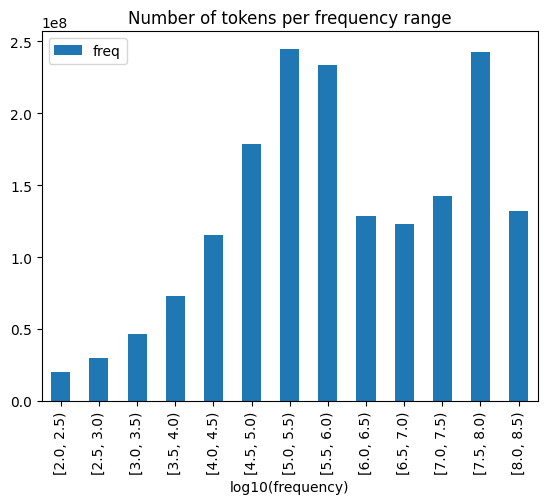

In [8]:
bins_tmp = np.arange(2, 9, .5)
groups_tmp = pd.cut(np.log10(df['freq']), bins=bins_tmp, right=False)
df.groupby(groups_tmp)[["freq"]].sum().plot(kind="bar")
plt.title("Number of tokens per frequency range")
plt.xlabel("log10(frequency)")
plt.show()

## Similarity matrices

For each combination of frequency groups, `N_SAMPLES` pairs of words are sampled at random, and the average similarity of the pairs is computed. 

In [9]:
SEMILLA = 33
N_SAMPLES = 500

### Similarity

In [10]:
if M_file.endswith("npz"):
    M = sparse.load_npz(M_file)
elif M_file.endswith("npy"):
    M = np.load(M_file)

In [11]:
# PNGs params
dpi = 300
width = 1500
height = 1150
nombre = "SGNS"

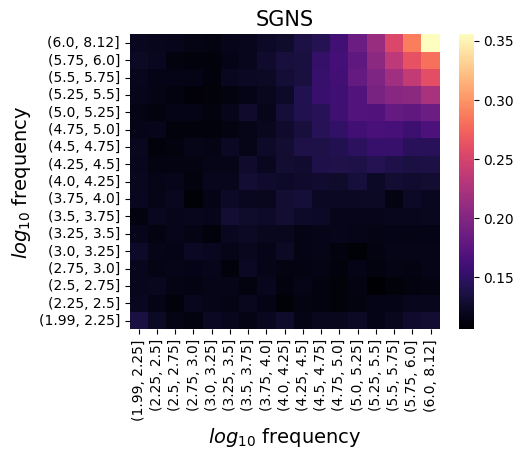

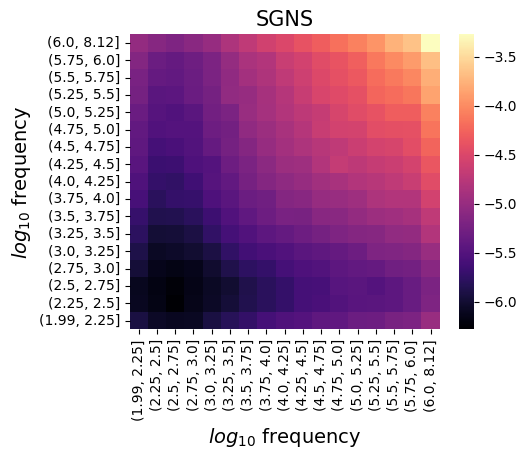

In [12]:
np.random.seed(SEMILLA)

df_similarity = create_similarity_df(
    df, M, 'freq_order', 'idx', n_samples=N_SAMPLES, normalize=True)

for c in ["cosine", "negative_distance"]:

    outfile = f"../results/plots/heatmap-{nombre}-{c}.png"
    ax = make_heatmap(df_similarity, 'freq_order', column=f"mean_{c}", cmap="magma")
    plt.title(nombre, fontsize=15)
    plt.xlabel("$log_{10}$ frequency", fontsize=14)
    plt.ylabel("$log_{10}$ frequency", fontsize=14)
    ax.figure.set_size_inches(width/dpi, height/dpi)
    plt.savefig(outfile, dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close(ax.figure)

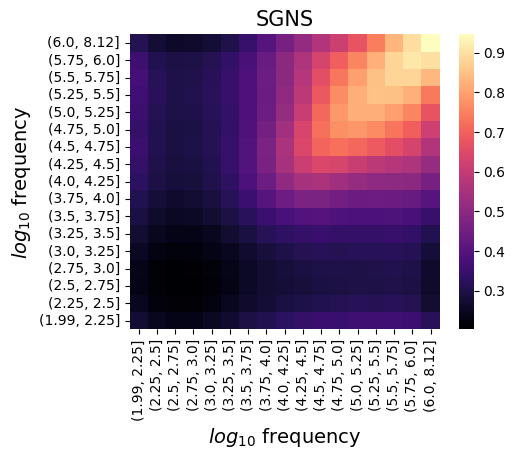

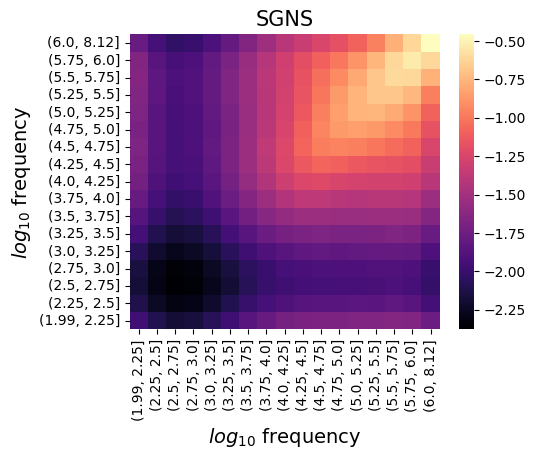

In [13]:
for i, f in enumerate(M_shuffled_files):
    
    if f.endswith("npz"):
        M_ = sparse.load_npz(f)
    elif f.endswith("npy"):
        M_ = np.load(f)

    np.random.seed(SEMILLA)

    df_shuf_ = create_similarity_df(
        df, M_, 'freq_order', 'idx', n_samples=N_SAMPLES, normalize=True)

    for c in ["cosine", "negative_distance"]:

        outfile = f"../results/plots/heatmap-{nombre}-{c}_s{i}.png"
        ax = make_heatmap(df_shuf_, 'freq_order', column=f"mean_{c}", cmap="magma")
        plt.title(nombre, fontsize=15)
        plt.xlabel("$log_{10}$ frequency", fontsize=14)
        plt.ylabel("$log_{10}$ frequency", fontsize=14)
        ax.figure.set_size_inches(width/dpi, height/dpi)
        plt.savefig(outfile, dpi=dpi, bbox_inches='tight')
        plt.show()
        plt.close(ax.figure)

    del M_

    if i == 1:
        break

### By epoch

In [18]:
# shuffled wiki
M_epochs_files = glob.glob("../data/working/w2v-wiki2021s1-V100-W10-D300-SG1-S1-NS5-NSE0.75-epoch*.model.wv.vectors.npy")
M_epochs_files = sorted(M_epochs_files)

print(M_epochs_files)

['../data/working/w2v-wiki2021s1-V100-W10-D300-SG1-S1-NS5-NSE0.75-epoch0.model.wv.vectors.npy', '../data/working/w2v-wiki2021s1-V100-W10-D300-SG1-S1-NS5-NSE0.75-epoch1.model.wv.vectors.npy', '../data/working/w2v-wiki2021s1-V100-W10-D300-SG1-S1-NS5-NSE0.75-epoch2.model.wv.vectors.npy', '../data/working/w2v-wiki2021s1-V100-W10-D300-SG1-S1-NS5-NSE0.75-epoch3.model.wv.vectors.npy', '../data/working/w2v-wiki2021s1-V100-W10-D300-SG1-S1-NS5-NSE0.75-epoch4.model.wv.vectors.npy', '../data/working/w2v-wiki2021s1-V100-W10-D300-SG1-S1-NS5-NSE0.75-epoch5.model.wv.vectors.npy']


In [19]:
def transform_matrix(arr):
    """Transpose matrix and leave one empty column with nans at the beginning
    so that it conforms to our format
    """
    arr = arr.T
    arr = np.insert(arr, 0, np.nan, axis=1)
    return arr

dpi = 300
width = 750
height = 600
nombre = "SGNS"

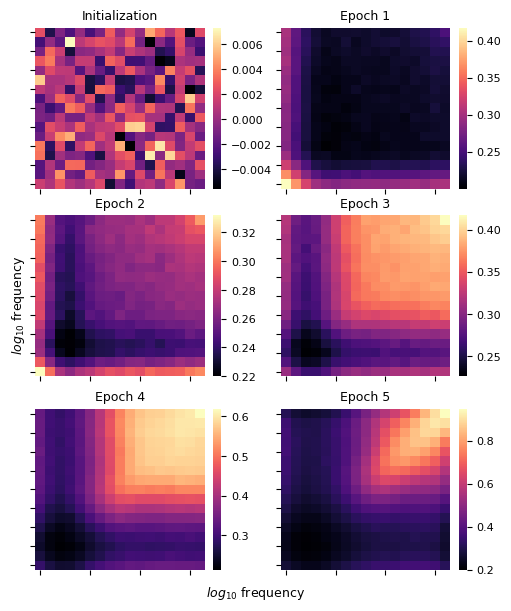

In [56]:
for c in ["cosine"]:
    # create a grid of 3x2 plots (i = 0,1,...,5):
    fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, layout='constrained',
                            figsize=(width/dpi*2, height/dpi*3))
    axs = axs.flatten()
    for i, f in enumerate(M_epochs_files):
        M_ = np.load(f)
        M_ = transform_matrix(M_)
        np.random.seed(SEMILLA)
        df_sim_ = create_similarity_df(
            df, M_, 'freq_order', 'idx', n_samples=N_SAMPLES, normalize=True)
        plt.sca(axs[i])
        make_heatmap(df_sim_, 'freq_order', column=f"mean_{c}", cmap="magma")
        if i == 0:
            plt.title(f"Initialization", fontsize=9)
        else:
            plt.title(f"Epoch {i}", fontsize=9)
        # No x and y labels:
        plt.xlabel(None)
        plt.ylabel(None)
        cbar = axs[i].figure.axes[-1]
        cbar.tick_params(labelsize=8)
        # remove x and y labels:
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
    fig.supxlabel("$log_{10}$ frequency", fontsize=9)
    fig.supylabel("$log_{10}$ frequency", fontsize=9)
    outfile = f"../results/plots/heatmap-{nombre}-{c}_epochs.png"
    plt.savefig(outfile, dpi=dpi, bbox_inches='tight')
    plt.show()
        

---------------------------